In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.onnx
import onnxruntime as ort
import matplotlib.pyplot as plt

# Load the datasets
df_trfcomplexity = pd.read_csv("data prep/meta_learningdata/final_dataframe_trfcomplexity.csv")
df_acas = pd.read_csv("data prep/meta_learningdata/final_acas_data.csv")

# Feature Engineering for TRF Complexity Data
df_trfcomplexity['FLT_DATE'] = pd.to_datetime(df_trfcomplexity['FLT_DATE'])
df_trfcomplexity['Quarter'] = df_trfcomplexity['FLT_DATE'].dt.quarter

# Handling non-numeric values for ACAS Dataset
print("Handling non-numeric values for ACAS Dataset...")
df_acas['Latitude'] = pd.to_numeric(df_acas['Latitude'], errors='coerce')
df_acas['Longitude'] = pd.to_numeric(df_acas['Longitude'], errors='coerce')
df_acas['Altitude'] = pd.to_numeric(df_acas['Altitude'], errors='coerce')
df_acas['Vertical Speed'] = pd.to_numeric(df_acas['Vertical Speed'], errors='coerce')
print("Handling non-numeric values for ACAS Dataset completed.")

#  Drop rows with NaN values
print("Dropping rows with NaN values...")
df_acas.dropna(subset=['Latitude', 'Longitude'], inplace=True)
print("NaN values dropped.")

# Risk Zones for ACAS Data
high_risk_zone_bounds = {'lat_min': 30, 'lat_max': 40, 'long_min': -100, 'long_max': -90}
df_acas['High_Risk_Zone'] = ((df_acas['Latitude'] >= high_risk_zone_bounds['lat_min']) &
                             (df_acas['Latitude'] <= high_risk_zone_bounds['lat_max']) &
                             (df_acas['Longitude'] >= high_risk_zone_bounds['long_min']) &
                             (df_acas['Longitude'] <= high_risk_zone_bounds['long_max'])).astype(int)

# Flight Condition Categories for ACAS Data
df_acas['Altitude_Category'] = pd.cut(df_acas['Altitude'], bins=[0, 5000, 10000, 15000, df_acas['Altitude'].max()],
                                      labels=['Low', 'Medium', 'High', 'Very High'], include_lowest=True)
df_acas['Vertical_Speed_Category'] = pd.cut(df_acas['Vertical Speed'], bins=[df_acas['Vertical Speed'].min(), -500, 500, df_acas['Vertical Speed'].max()],
                                            labels=['Rapid Descent', 'Stable', 'Rapid Ascent'], include_lowest=True)

# Combine features from both datasets
combined_features = pd.concat([df_trfcomplexity.drop(['FLT_DATE'], axis=1),
                               pd.get_dummies(df_acas.drop(['Latitude', 'Longitude'], axis=1))], axis=1)



# Create a synthetic target variable for demonstration
y = np.random.randint(0, 2, size=len(combined_features))
# Checking for NaN values in combined_features
if combined_features.isnull().any().any():
    print("NaN values detected in combined features. Handling...")
    
    #  Drop rows with any NaN values
    combined_features.dropna(inplace=True)
    print("Rows with NaN values have been dropped.")

y = y[combined_features.index]


Handling non-numeric values for ACAS Dataset...
Handling non-numeric values for ACAS Dataset completed.
Dropping rows with NaN values...
NaN values dropped.
NaN values detected in combined features. Handling...
Rows with NaN values have been dropped.


NaN values detected in combined features. Handling...
Rows with NaN values have been dropped.


In [17]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.1, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


In [39]:


# Training loop
model = SimpleNN(input_size=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5

# for epoch in range(epochs):
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs.squeeze(), labels)
#         loss.backward()
#         optimizer.step()
        
            
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs)

#         # Ensure output is flattened without removing necessary dimensions
#         outputs = outputs.view(-1)

#         # Calculate loss
#         loss = criterion(outputs, labels)

#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()

#     print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
# Training loop
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        # Check the range of outputs
        print(f"Min value in outputs: {outputs.min().item()}, Max value in outputs: {outputs.max().item()}")
        if torch.isnan(outputs).any() or torch.isinf(outputs).any():
          print("NaN or Inf found in outputs")
        #break
        #  outputs are flattened and remain within the [0, 1] range
        outputs = outputs.view(-1)
        

        # Ensure labels are float type
        labels = labels.float()
        
      

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    



# Convert to ONNX
dummy_input = torch.randn(1, X_train.shape[1])
torch.onnx.export(model, dummy_input, "data prep/meta_learningdata/accident_prediction.onnx")
print("model created.")

# Re-export the ONNX model with the correct dummy input
dummy_input = torch.randn(1, X_train.shape[1])
torch.onnx.export(model, dummy_input, "data prep/meta_learningdata/accident_prediction.onnx")
print("ONNX model re-exported.")

import onnx

# Load and verify the ONNX model
onnx_model = onnx.load("data prep/meta_learningdata/accident_prediction.onnx")
input_shape = onnx_model.graph.input[0].type.tensor_type.shape.dim
print("ONNX model input shape:", [dim.dim_value for dim in input_shape])




Min value in outputs: 0.38036543130874634, Max value in outputs: 0.59572434425354
Min value in outputs: 0.41048765182495117, Max value in outputs: 0.5710033774375916
Min value in outputs: 0.3619394302368164, Max value in outputs: 0.5672900676727295
Min value in outputs: 0.39184993505477905, Max value in outputs: 0.5655572414398193
Min value in outputs: 0.33141016960144043, Max value in outputs: 0.5763547420501709
Min value in outputs: 0.3695289194583893, Max value in outputs: 0.5443556308746338
Min value in outputs: 0.38700103759765625, Max value in outputs: 0.6029952168464661
Min value in outputs: 0.3987346887588501, Max value in outputs: 0.62948077917099
Min value in outputs: 0.38856935501098633, Max value in outputs: 0.5930121541023254
Min value in outputs: 0.3662698566913605, Max value in outputs: 0.6169114708900452
Min value in outputs: 0.4095458984375, Max value in outputs: 0.5788229703903198
Min value in outputs: 0.4119170010089874, Max value in outputs: 0.6007581949234009
Min v

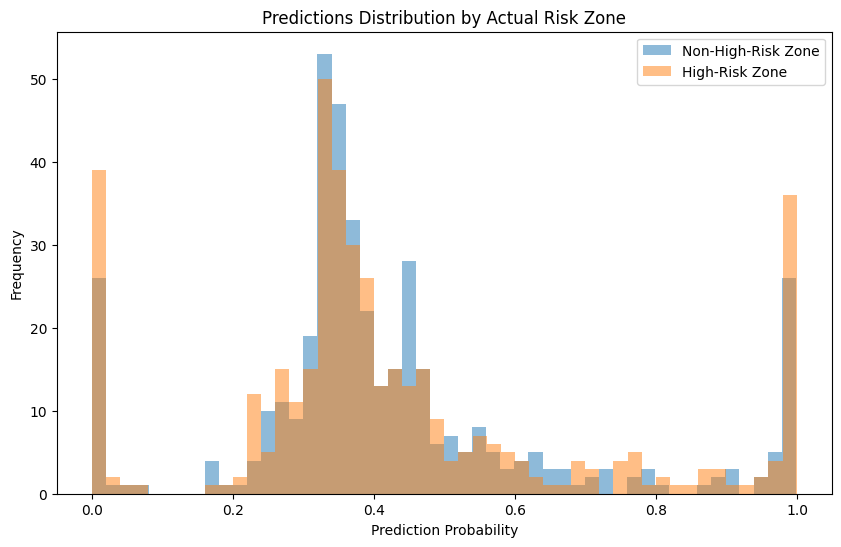

In [40]:
import numpy as np
import onnxruntime as ort
# Load the ONNX model
ort_session = ort.InferenceSession('data prep/meta_learningdata/accident_prediction.onnx')

# Function to preprocess and predict for a single sample
def preprocess_and_predict(sample, ort_session):
    # Reshape the sample to match the model's input shape
    sample_reshaped = sample.reshape(1, -1)  # Reshaping to (1, 7860)

    # Prepare the input for the ONNX model
    ort_inputs = {ort_session.get_inputs()[0].name: sample_reshaped.astype(np.float32)}

    # Run inference
    ort_outs = ort_session.run(None, ort_inputs)

    return ort_outs[0]  

# Iterate over each sample in X_test_scaled and make predictions
predictions = [preprocess_and_predict(X_test_scaled[i], ort_session) for i in range(X_test_scaled.shape[0])]

#  flatten the list of predictions
predictions_flattened = np.concatenate(predictions, axis=0)

# predictions_flattened will now contain the model's predictions for each sample

# Results Plotting
plt.figure(figsize=(10, 6))
plt.hist(predictions_flattened[y_test == 0], bins=50, alpha=0.5, label='Non-High-Risk Zone')
plt.hist(predictions_flattened[y_test == 1], bins=50, alpha=0.5, label='High-Risk Zone')
plt.title('Predictions Distribution by Actual Risk Zone')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

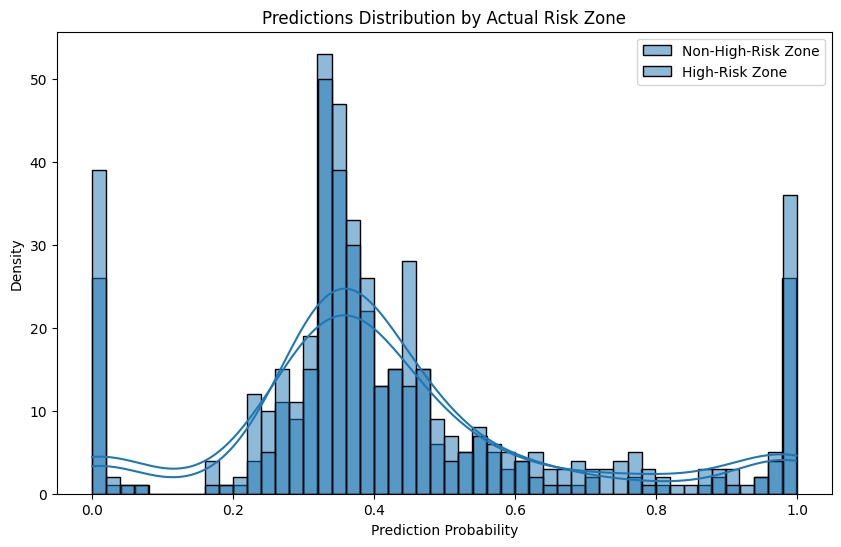

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Enhanced Histogram
plt.figure(figsize=(10, 6))
sns.histplot(predictions_flattened[y_test == 0], bins=50, kde=True, color="blue", alpha=0.5, label='Non-High-Risk Zone')
sns.histplot(predictions_flattened[y_test == 1], bins=50, kde=True, color="red", alpha=0.5, label='High-Risk Zone')
plt.title('Predictions Distribution by Actual Risk Zone')
plt.xlabel('Prediction Probability')
plt.ylabel('Density')
plt.legend()
plt.show()


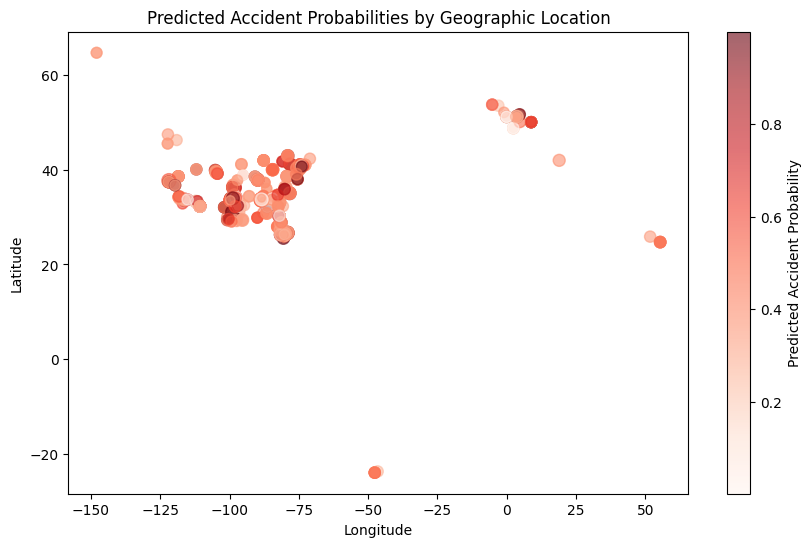

In [50]:
# Extract geographic data corresponding to X_test entries
test_geodata = df_acas.iloc[test_indices][['Latitude', 'Longitude', 'Vertical Speed']]

# Normalize 'Vertical Speed' for visualization purposes
speeds_normalized = (test_geodata['Vertical Speed'] - test_geodata['Vertical Speed'].min()) / (test_geodata['Vertical Speed'].max() - test_geodata['Vertical Speed'].min()) * 100 + 10

# Visualization
plt.figure(figsize=(10, 6))
sc = plt.scatter(test_geodata['Longitude'], test_geodata['Latitude'], c=predictions_flattened, cmap='Reds', s=speeds_normalized, alpha=0.6)
plt.colorbar(sc, label='Predicted Accident Probability')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predicted Accident Probabilities by Geographic Location')
plt.show()

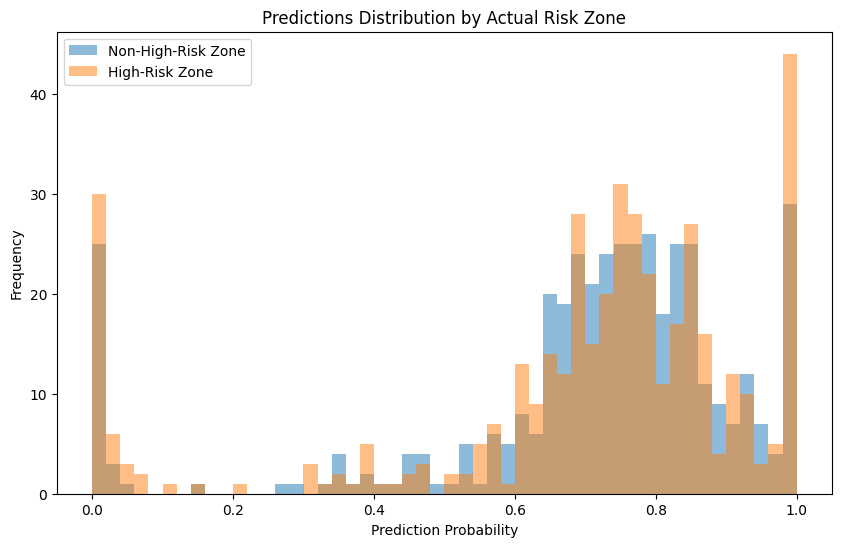

In [38]:
import numpy as np
import onnxruntime as ort



# Load the ONNX model
ort_session = ort.InferenceSession('data prep/meta_learningdata/accident_prediction.onnx')

# Function to preprocess and predict for a single sample
def preprocess_and_predict(sample, ort_session):
    # Reshape the sample to match the model's input shape
    sample_reshaped = sample.reshape(1, -1)  # Reshaping to (1, 7860)

    # Prepare the input for the ONNX model
    ort_inputs = {ort_session.get_inputs()[0].name: sample_reshaped.astype(np.float32)}

    # Run inference
    ort_outs = ort_session.run(None, ort_inputs)

    return ort_outs[0]  

# Iterate over each sample in X_test_scaled and make predictions
predictions = [preprocess_and_predict(X_test_scaled[i], ort_session) for i in range(X_test_scaled.shape[0])]

#  flatten the list of predictions
predictions_flattened = np.concatenate(predictions, axis=0)

# predictions_flattened will now contain the model's predictions for each sample

# Results Plotting
plt.figure(figsize=(10, 6))
plt.hist(predictions_flattened[y_test == 0], bins=50, alpha=0.5, label='Non-High-Risk Zone')
plt.hist(predictions_flattened[y_test == 1], bins=50, alpha=0.5, label='High-Risk Zone')
plt.title('Predictions Distribution by Actual Risk Zone')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()


